In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

# DELETE LATER
# function to display df info
def df_peek(df):
    display(type(df), df.shape, df.dtypes, df.sample(2))

## Read in merged fta/tircp/dgs data from cleaner script

In [2]:
all_bus = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/cpb_analysis_data_merge.parquet"
)

## Aggregate
To get total funding and bus count
- per agency
- per propulsion type
- per bus size type

In [36]:
# test to edit total cpb to be a calculated col (outside of the .aggfuc())


def cpb_aggregate(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    function to aggregate compiled data by different categories (transit agency, propulsion type, size type).
    aggregate on columns:
        "project_title"
        "ppno"
        "total_cost"
        "bus_count"
        
    Then, cost per bus is calculated AFTER the aggregation.
    """
    df_agg = (
        df.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_project_count_ppno=("ppno", "count"),
            total_funds=("total_cost", "sum"),
            total_bus_count=("bus_count", "sum"),
        )
        .reset_index()
    )
    df_agg["cpb"] = (df_agg["total_funds"] / df_agg["total_bus_count"]).astype("int64")
    return df_agg


# create dfs that group by agency, prop type and size type
agency_agg = cpb_aggregate(all_bus,"transit_agency")
prop_agg = cpb_aggregate(all_bus,"prop_type")
size_agg = cpb_aggregate(all_bus,"bus_size_type")

In [ ]:
display(
    agency_agg,
    prop_agg,
    size_agg
)

In [8]:
# add new column for z-score
all_bus["zscore_cost_per_bus"] = zscore(all_bus["cost_per_bus"])

# remove outliers
# filter df for zscores between -3 and 3
zscore_bus = all_bus[
    (all_bus["zscore_cost_per_bus"] >= -3) & (all_bus["zscore_cost_per_bus"] <= 3)
]

In [11]:
list(all_bus.prop_type.sort_values().unique())

['BEB',
 'CNG',
 'FCEB',
 'electric (not specified)',
 'ethanol',
 'low emission (hybrid)',
 'low emission (propane)',
 'mix (diesel and gas)',
 'mix (zero and low emission)',
 'not specified',
 'zero-emission bus (not specified)']

## Zeb Only DF

In [12]:
# Zeb only df and Count of ZEB
zeb_only = all_bus[
    all_bus["prop_type"].isin(
        [
            'BEB',
            #'CNG',
            'FCEB',
            'electric (not specified)',
            #'ethanol',
            #'low emission (hybrid)',
            #'low emission (propane)',
            #'mix (diesel and gas)',
            #'mix (zero and low emission)',
            #'not specified',
            'zero-emission bus (not specified)' 
        ]
    )
]

# zeb agg
zeb_agg = bus_aggregate("prop_type", df=zeb_only)


# zeb-only, no outliers
zeb_only_no_outliers = zeb_only[
    (zeb_only["zscore_cost_per_bus"] >= -3) & (zeb_only["zscore_cost_per_bus"] <= 3)
]

In [14]:
zeb_agg

,prop_type,total_project_count,total_funds,total_bus_count,cpb
0,BEB,19,748108908,635.0,1178124
1,FCEB,5,217443270,116.0,1874510
2,electric (not specified),12,261524312,211.0,1239451
3,zero-emission bus (not specified),5,1820638793,829.0,2196186


## Non-ZEB only DF

In [13]:
# non-zeb df and Count of non-ZEB
non_zeb_only = all_bus[
    all_bus["prop_type"].isin(
        [         
            'CNG',
            'ethanol',
            'low emission (hybrid)',
            'low emission (propane)',
            'mix (diesel and gas)',
            'mix (zero and low emission)',
        ]
    )
]

non_zeb_agg = bus_aggregate("prop_type", df=non_zeb_only)

In [15]:
non_zeb_agg

,prop_type,total_project_count,total_funds,total_bus_count,cpb
0,CNG,3,50805854,87.0,583975
1,ethanol,1,1006750,9.0,111861
2,low emission (hybrid),18,97437108,151.0,645278
3,low emission (propane),7,15564547,54.0,288232
4,mix (diesel and gas),1,3303600,9.0,367066
5,mix (zero and low emission),4,75264268,147.0,512001


### Z-score for cost_per_bus 

## Chart functions 

In [22]:
# distribution curve of cost per bus. no outliers


def dist_curve(
    df,
    mean,
    std,
    title="Cost Per Bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
):
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )

    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 2, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + std * 3, color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return

In [27]:
# chart function

def make_chart(y_col, title, data=zscore_bus, x_col="transit_agency"):
    data.sort_values(by=y_col, ascending=False).head(10).plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

## Summary

In [28]:
# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.total_cost)
min_bus_cost = all_bus.cost_per_bus.min()
max_bus_cost = all_bus.cost_per_bus.max()
max_bus_count = all_bus.bus_count.max()


cpb_mean = zscore_bus.cost_per_bus.mean()
cpb_std = zscore_bus.cost_per_bus.std()

# agency with highest bus count
agency_with_most_bus = all_bus.loc[all_bus["bus_count"].idxmax(), "transit_agency"]

# propulsion type max count and name
prop_type_name_max_freq = all_bus["prop_type"].value_counts().idxmax()
prop_type_max = all_bus["prop_type"].value_counts().max()

# prop type min count and anme
prop_type_name_min_freq = all_bus["prop_type"].value_counts().idxmin()
prop_type_min = all_bus["prop_type"].value_counts().min()

# how many buses do they have? already answered
agency_with_highest_funds = all_bus.loc[
    all_bus["total_cost"].idxmax(), "transit_agency"
]

# what is the highest amount? already answered
agency_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "transit_agency"]
agency_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "transit_agency"]
prop_type_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "prop_type"]
prop_type_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "prop_type"]


zeb_count = len(zeb_only.prop_type)


non_zeb_count = len(non_zeb_only.prop_type)

# zeb only, no outliers cpb curve
zeb_only_mean = zeb_only_no_outliers.cost_per_bus.mean()
zeb_only_std = zeb_only_no_outliers.cost_per_bus.std()

# non-zeb cpb mean and std dev
non_zeb_only_mean = non_zeb_only.cost_per_bus.mean()
non_zeb_only_std = non_zeb_only.cost_per_bus.std()

# start summary narative
summary = f"""

This analysis examines the 'cost' of buses as it relates to grant award dollars. Specifically, transit agencies who were awarded grants to fund projects that include procuring buses and/or other transit related equipment, and how much variance there was in procuring buses. 

As of today, data was scraped from these sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)

Analyzing the dataset uncovered several nuances. Some projects included additional components besides bus purchases (chargers, transit facilities, parts, training), whereas other projects only purchased bus, and some did not include any bus purchases at all. The variety in these projects may contribute to high variances in “cost per bus”.
Additionally, some projects do not accurately or describe the propulsion or bus size type. There are numerous instances where transit agencies reported procuring “zero-emission buses” (ZEBs) but does not specify if the buses are battery electric, fuel-cell, etc. Or transit agencies state conflicting information such as procuring “hybrid electric ZEBs”. In all cases, the dataset was examined for inconsistencies and data was validated to complete the analysis.
Datasets was filtered to only include data that specified the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per bus' metric was calculated by dividing the total funding received by the total number of buses they procured.
Initial finding uncovered some outliers where a transit agency’s cost per bus figure exceeded 3 standard deviations away from the mean. Deeper investigations conclude that these projects also include major infrastructure replacements.

Overall:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest awarded dollars per bus for an agency was ${max_bus_cost:,.2f} for a {prop_type_max_cpb}, belonging too {agency_max_cpb}. 
    - The lowest awarded dollars per bus for an agency was ${min_bus_cost:,.2f} for a {prop_type_min_cpb}, belonging too {agency_min_cpb}.

The agency with the most buses procured was {agency_with_most_bus} with {max_bus_count} buses.


Propulsion type values varied wildly amongst the datasets. Data was validated and grouped as best as possible based on project description or other indications of specific propulsion type.
The following is a summary of propulsion type metrics.
     - The most common propulsion type that was proceeded was "{prop_type_name_max_freq}".
     - The number of zero-emission buses procured (electric, battery-electric and fuel-cell electric) is {zeb_count}.
     - the number of non-zero emission buses procured (CNG, hybrids, other alternate fuels) is {non_zeb_count}.
     
The following was discovered after removing outliers, :
    - overall the average awarded dollars per bus is ${cpb_mean:,.2f}, with a standard deviation of  ${cpb_std:,.2f}. 
    - the average awarded dollars per ZEB is ${zeb_only_mean:,.2f}, with a standard deviation of ${zeb_only_std:,.2f}.
    - the average awarded dollars per non-ZEB ${non_zeb_only_mean:,.2f}, with a standard deviation of ${non_zeb_only_std:,.2f}.


Below are key charts that summarize the findings.

"""



This analysis examines the 'cost' of buses as it relates to grant award dollars. Specifically, transit agencies who were awarded grants to fund projects that include procuring buses and/or other transit related equipment, and how much variance there was in procuring buses. 

As of today, data was scraped from these sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)

Analyzing the dataset uncovered several nuances. Some projects included additional components besides bus purchases (chargers, transit facilities, parts, training), whereas other projects only purchased bus, and some did not include any bus purchases at all. The variety in these projects may contribute to high variances in “cost per bus”.
Additionally, some projects do not accurately or describe the propulsion or bus size type. There are numerous instances where transit agencies reported procuring “zero-e

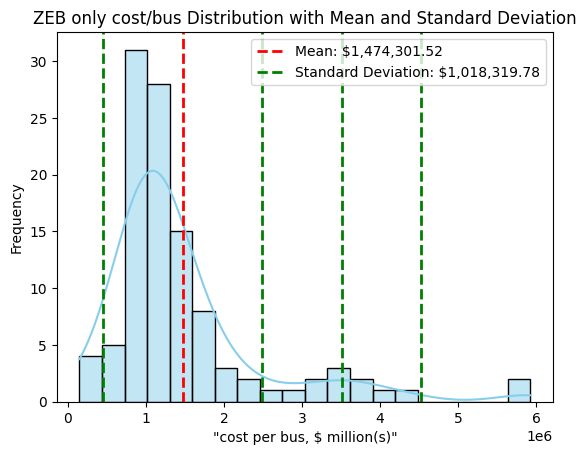


non-ZEB only cost/bus Distribution. This distrubtion is is much more spread out and with a smaller standard deviation.


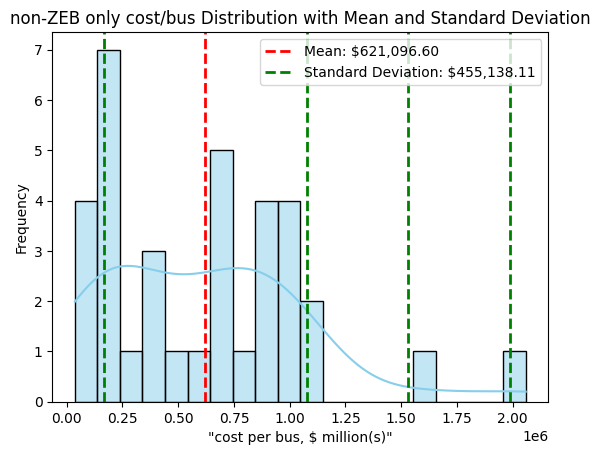


Most funds Awarded by Transit Agency. LA Metro was awarded almost double the next agency.


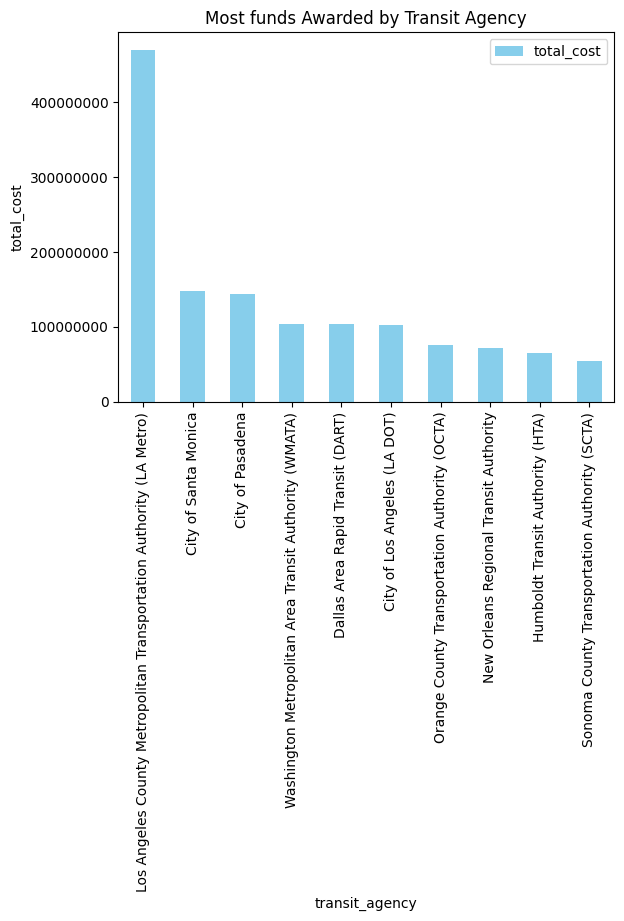


Highest Bus Count by Agency. LA Metro plans to procure the most buses.


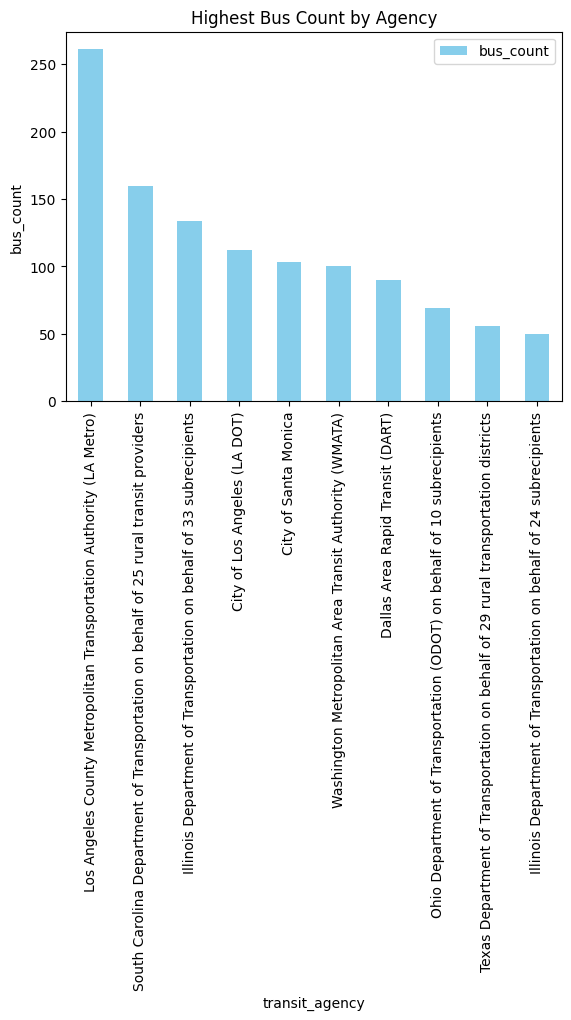


Cost per bus by propulsion type. the total cost per bus for ZEB categories do fall within a similar range of eachother.


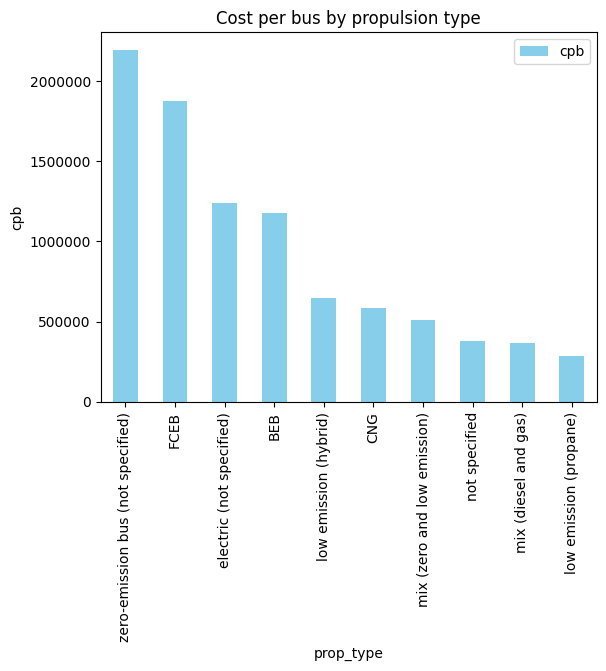


Bus count by propulsion type. The most common bus type procured were zero-emissions related.


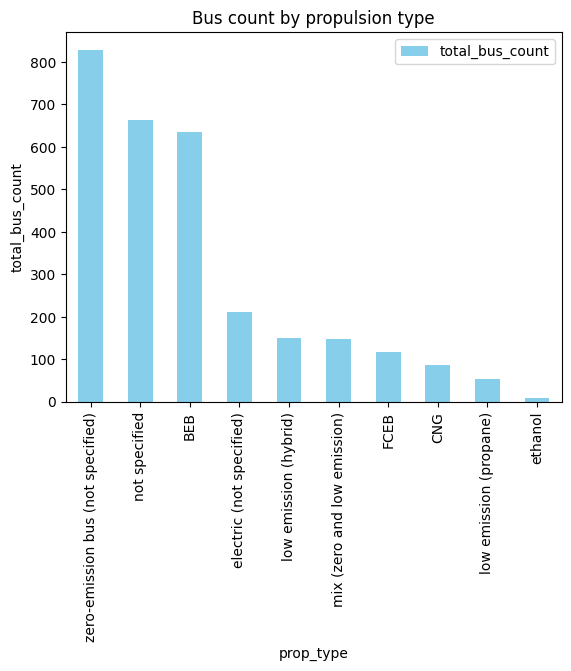


Based on the findings so far, there is data to  supports that bus procurement cost vary widely amongst transit agencies all over the country. 
More so with non-ZEB buses than ZEB buses. Upon reading deeper into the data, it appears transit agencies are still in the early stages of adopting ZEB and capital improvement (building improvement, initial charging infrastructure installation) are needed at this time. 
Cost per bus is suspected to normalize once infrastructure changes are no longer included in projects, and bus only purchases remain. 


In [29]:
print(summary)


# CHARTS
# ZEB only, cpb distribution
print(
    """
ZEB only cost/bus Distribution Chart. 
The majority of the distribution is within +/-1 standard deviation of the mean, however the standard deviation is quite wide at ~$800,000."""
)
dist_curve(
    zeb_only_no_outliers,
    zeb_only_mean,
    zeb_only_std,
    title="ZEB only cost/bus Distribution",
)

# non_zeb distribution
print(
    """
non-ZEB only cost/bus Distribution. This distrubtion is is much more spread out and with a smaller standard deviation."""
)
dist_curve(
    non_zeb_only,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
)

# Higest awarded funds by agency
print(
    """
Most funds Awarded by Transit Agency. LA Metro was awarded almost double the next agency."""
)
make_chart("total_cost", "Most funds Awarded by Transit Agency")

# Highest bus count
print(
    """
Highest Bus Count by Agency. LA Metro plans to procure the most buses."""
)
make_chart("bus_count", "Highest Bus Count by Agency")

# COST PER BUS BY PROP TYPE
print(
    """
Cost per bus by propulsion type. the total cost per bus for ZEB categories do fall within a similar range of eachother."""
)
make_chart("cpb", "Cost per bus by propulsion type", x_col="prop_type", data=prop_agg)

# bus count BY PROP TYPE
print(
    """
Bus count by propulsion type. The most common bus type procured were zero-emissions related."""
)
make_chart(
    "total_bus_count", "Bus count by propulsion type", x_col="prop_type", data=prop_agg
)

print(
    """
Based on the findings so far, there is data to  supports that bus procurement cost vary widely amongst transit agencies all over the country. 
More so with non-ZEB buses than ZEB buses. Upon reading deeper into the data, it appears transit agencies are still in the early stages of adopting ZEB and capital improvement (building improvement, initial charging infrastructure installation) are needed at this time. 
Cost per bus is suspected to normalize once infrastructure changes are no longer included in projects, and bus only purchases remain. """
)

---
# Deprecated

## Game Plan
- <s>bring in both data sets (FTA Press Release and TIRCP bus data
- <s>FTA data, make sure it only has rows with bus count > 0
- may need to clean up the prop type and bus size type if there are any similar categories (completed at FTA notebook)
- <s>Create shorten data frames for each. include the following columns:
    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)
<br>
<br>
- <s>concat the short dataframes
- <s>start aggregation. sum/count bus count, funding and project #
    * agg by agency name
    * agg by prop type
    * agg by bus size type

- <s>new column for Z-score of `cost_per_bus`
- rerun stats sumamry
- use functions to make charts

## Charts
By Agency
- most awarded dollars
- most bus count
- highest cpb
- Most frequent prop_type procured

By prop_type
- most awarded dollars
- most bus count
- highest cpb
- Most frequent prop_type

Just zero emission
(electric, beb, fceb, mix(beb and fceb))
- most awarded dollars
- most bus count
- highest cpb

Stats Curves
- distribution of cpb
- 


### Charts by Agency

In [ ]:
# most awarded dollars by agency
make_chart("project_award_amount", "Most funds awarded by Transit Agency")

In [ ]:
# Highest bus count by agency
make_chart("bus_count", "Most buses procured by Transit Agency")

In [ ]:
# highest cost per bus by agency
make_chart("cost_per_bus", "Highest overall cost per bus (cps) by Transit Agency")

In [ ]:
# most frequent prop_type by agency
prop_type_freq = all_bus.prop_type.value_counts().reset_index()
prop_type_freq.columns = ["prop_type", "freq"]
make_chart(
    "freq",
    "Most frequent propulsion type mentioned",
    x_col="prop_type",
    data=prop_type_freq,
)

### Charts By `prop_type`

In [ ]:
# COST PER BUS BY PROP TYPE
# using prop_agg df and 'total_funds'
make_chart(
    "total_funds", "award amount by propulsion type", x_col="prop_type", data=prop_agg
)

In [ ]:
# COST PER BUS BY PROP TYPE
make_chart("cpb", "cost per bus by propulsion type", x_col="prop_type", data=prop_agg)

In [ ]:
# bus count BY PROP TYPE
make_chart(
    "total_bus_count",
    "cost per bus by propulsion type",
    x_col="prop_type",
    data=prop_agg,
)

In [ ]:
# what is the average cps for each prop_type?
prop_agg

### ZEB Only chart
`zeb_only`

In [ ]:
make_chart(
    "total_funds",
    "award amount for ZEBs, by propulsion type",
    x_col="prop_type",
    data=zeb_agg,
)
make_chart(
    "total_cpb", "ZEB cost per bus by propulsion type", x_col="prop_type", data=zeb_agg
)
make_chart(
    "total_bus_count",
    "ZEB bus count by propulsion type",
    x_col="prop_type",
    data=zeb_agg,
)

### Non ZEB df
`non_zeb_only`

In [ ]:
make_chart(
    "total_funds",
    "award amount for non-ZEB by propulsion type",
    x_col="prop_type",
    data=non_zeb_agg,
)
make_chart(
    "total_cpb",
    "non-ZEB cost per bus by propulsion type",
    x_col="prop_type",
    data=non_zeb_agg,
)
make_chart(
    "total_bus_count",
    "non-ZEB bus count by propulsion type",
    x_col="prop_type",
    data=non_zeb_agg,
)

### Stat Dist Curves

In [ ]:
# overall cpb
dist_curve(zscore_bus, cpb_mean, cpb_std)

In [ ]:
# zeb-only, no outliers
zeb_only_no_outliers = zeb_only[
    (zeb_only["zscore_cost_per_bus"] >= -3) & (zeb_only["zscore_cost_per_bus"] <= 3)
]

# zeb only, no outliers cpb curve
zeb_only_mean = zeb_only_no_outliers.cost_per_bus.mean()
zeb_only_std = zeb_only_no_outliers.cost_per_bus.std()

# non-zeb cpb mean and std dev
non_zeb_only_mean = non_zeb_only.cost_per_bus.mean()
non_zeb_only_std = non_zeb_only.cost_per_bus.std()

dist_curve(
    zeb_only_no_outliers,
    zeb_only_mean,
    zeb_only_std,
    title="ZEB only cost/bus Distribution",
)

In [ ]:
# non-zeb cpb curve
non_zeb_only_mean = non_zeb_only.cost_per_bus.mean()
non_zeb_only_std = non_zeb_only.cost_per_bus.std()

dist_curve(
    non_zeb_only,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
)

In [ ]:
# distribution curve of zscore
sns.histplot(zscore_bus["zscore_cost_per_bus"], kde=True, color="skyblue", bins=20)
plt.title("Cost Per Bus Z-Score Distribution")
plt.xlabel("zscore cost per bus")
plt.ylabel("Frequency")
plt.show()